# Vector Database Comparison For AI Workloads: Elasticsearch vs MongoDB Atlas Vector Search


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mongodb-developer/GenAI-Showcase/blob/main/notebooks/benchmarks/vector_database_comparison_mongodb_elastic.ipynb)
-----

This notebook implements and benchmarks a standard AI workload that involves vector embeddings and the retreival of semantically similar documents from a database. 

The benchmark comparison notebook uses two different vector databases:
- Elasticsearch: A distributed, RESTful search and analytics engine capable of performing real-time data ingestion, search, and analytics.
- MongoDB Atlas Vector Search: A vector search feature for MongoDB Database that enables vector search on the database.


## Key Information

1. **System Configuration**

| Component | Specification |
|-----------|---------------|
| **Hardware** ||
| System | MacBook Pro 16-inch, 2023 |
| CPU | Apple M2 Pro |
| Memory | 16GB |
| **Database Tools** ||
| Kibana | 8.17.0 |
| MongoDB Management | MongoDB Compass (v1.41.0) |
| **Database Versions** ||
| Elasticsearch | 8.17.0 |
| - Index Configuration | HNSW index with m=16 (default), ef_construction=100 (default) and cosine similarity |
| - Search Configuration | num_candidates = 150 candidate matches, num of results to return 'k' = 5 |
| MongoDB | 8.0.1 with Atlas CLI (Single Node) |
| - Index Configuration | HNSW index with m=16 (default), ef_construction=100 (default) and cosine similarity |
| - Search Configuration | numCandidates = 150 candidate matches, num of results to return 'limit' = 5 |
| **Container Environment** ||
| Docker Desktop | 4.34.3 |
| Docker Engine | 27.2.0 |
| Docker Compose | v2.29.2-desktop.2 |
| Kubernetes | v1.30.2 |
| **Docker Resource Pool** ||
| Total CPU | 12 cores |
| Total Memory | 7.9 GB |
| Total Swap | 1 GB |
| Virtual Disk | 64 GB |
| Container Memory Limit | 7.65GB |
| **Development Environment** ||
| Python | 3.11.5 |
| Pip | 24.2 |
| IDE | Jupyter Notebook |
| Operating System | macOS Sonoma 14.2.1 |
2. **Data Processing**
   - Uses Wikipedia dataset (100,000 entries) with embeddings(Precision: float32, Dimensions: 768) generated by Cohere
   - JSON data is generated from the dataset and stored in the databases
   - Stores data in both Elasticsearch and MongoDB

3. **Performance Testing**
   - Tests different sizes of concurrent queries (1-400 queries)
   - Tests different insertion batch sizes and speed of insertion

| Operation  | Metric | Description |
|------------|--------|-------------|
| Insertion  | Latency | Time taken to insert the data (average response time) |
|            | Throughput | Number of queries processed per second |
| Retrieval  | Latency | Time taken to retrieve the top n results (average response time) |
|            | Throughput | Number of queries processed per second |
|            | P95 Latency | Time taken to retrieve the top n results for 95% of the queries |
|            | Standard Deviation | How much the latency varies from the average latency |

4. **Results Visualization**
   - Interactive animations showing request-response cycles
   - Comparative charts for latency and throughput
   - Performance analysis across different batch sizes

## Part 1: Data Setup

Setting up the benchmark results dictionary `benchmark_results` and the batch sizes to test `CONCURRENT_QUERIES` and `TOTAL_QUERIES`

- `benchmark_results` is a dictionary that will store the results of the benchmark tests
- `CONCURRENT_QUERIES` is a list of the number of queries that are run concurrently
- `TOTAL_QUERIES` is the total number of queries that are run

Benchmark Configuration Example:
When testing with a concurrency level of 10:
- We run 100 iterations
- Each iteration runs 10 concurrent queries
- Total queries = 1,000 queries (TOTAL_ITERATIONS * CONCURRENT_QUERIES)

NOTE: For each concurrency level in CONCURRENT_QUERIES:
1. Run TOTAL_QUERIES iterations
2. In each iteration, execute that many concurrent queries
3. Measure and collect latencies for all queries



In [2]:
# Initialize the benchmark results dictionary
benchmark_results = {
    "Elasticsearch": {},
    "MongoDB": {}
}

# The concurrency levels for benchmark testing
# Each level represents the number of simultaneous queries to execute
CONCURRENT_QUERIES = [1, 2, 4, 5, 8, 10, 12, 16, 20, 24, 32, 40, 48, 50, 56, 64, 72, 80, 88, 96, 100, 200, 400]

# The total number of iterations to run for each concurrency level
TOTAL_QUERIES=100

In [3]:
import os
import getpass

# Function to securely get and set environment variables
def set_env_securely(var_name, prompt):
  value = getpass.getpass(prompt)
  os.environ[var_name] = value

### Step 1: Install Libraries

All the libraries are installed using pip and facilitate the sourcing of data, embedding generation, and data visualization.

- `datasets`: Hugging Face library for managing and preprocessing datasets across text, image, and audio (https://huggingface.co/datasets)
- `sentence_transformers`: For creating sentence embeddings for tasks like semantic search and clustering. (https://www.sbert.net/)
- `pandas`: A library for data manipulation and analysis with DataFrames and Series (https://pandas.pydata.org/)
- `matplotlib`: A library for creating static, interactive, and animated data visualizations (https://matplotlib.org/)
- `seaborn`: A library for creating statistical data visualizations (https://seaborn.pydata.org/)
- `cohere`: A library for generating embeddings and accessing the Cohere API or models (https://cohere.ai/)

In [4]:
%pip install --upgrade --quiet datasets sentence_transformers pandas matplotlib seaborn cohere

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
eland 8.12.1 requires pandas<2,>=1.5, but you have pandas 2.2.3 which is incompatible.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Step 2: Data Loading

The dataset for the benchmark is sourced from the Hugging Face Cohere Wikipedia dataset.

The [Cohere/wikipedia-22-12-en-embeddings](https://huggingface.co/datasets/Cohere/wikipedia-22-12-en-embeddings) dataset on Hugging Face comprises English Wikipedia articles embedded using Cohere's multilingual-22-12 model. Each entry includes the article's title, text, URL, Wikipedia ID, view count, paragraph ID, language codes, and a 768-dimensional embedding vector. This dataset is valuable for tasks like semantic search, information retrieval, and NLP model training.

For this benchmark, we are using 100,000 rows of the dataset and have removed the id, wiki_id, paragraph_id, langs and views columns.

In [5]:
import pandas as pd
from datasets import load_dataset

# Using 100,000 rows for testing, feel free to change this to any number of rows you want to test
# The wikipedia-22-12-en-embeddings dataset has approximately 35,000,000 rows and requires 120GB of memory to load
MAX_ROWS = 100000

dataset = load_dataset("Cohere/wikipedia-22-12-en-embeddings", split="train", streaming=True)
dataset_segment = dataset.take(MAX_ROWS)

# Convert the dataset to a pandas dataframe
dataset_df = pd.DataFrame(dataset_segment)

/Users/richmondalake/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Add a JSON attribute to the dataset consisting of the title, text and url
dataset_df['json_data'] = dataset_df.apply(
    lambda row: {
        'title': row['title'],
        'text': row['text'],
        'url': row['url']
    },
    axis=1
)

In [7]:
# Remove the id field, wiki_id, paragraph_id, langs and views from the dataset
# This is to replicate the structure of dataset usually encountered in AI workloads, particularly in RAG systems where metadata is extracted from documents and stored.
dataset_df = dataset_df.drop(columns=['id', 'wiki_id', 'paragraph_id', 'langs', 'views'])

In [8]:
# Change the emb colomn name to embedding
dataset_df = dataset_df.rename(columns={'emb': 'embedding'})

In [9]:
dataset_df.head(5)

,title,text,url,embedding,json_data
0,Deaths in 2022,The following notable deaths occurred in 2022....,https://en.wikipedia.org/wiki?curid=69407798,"[0.2865696847438812, -0.03181683272123337, 0.0...","{'title': 'Deaths in 2022', 'text': 'The follo..."
1,YouTube,YouTube is a global online video sharing and s...,https://en.wikipedia.org/wiki?curid=3524766,"[-0.09689381718635559, 0.1619211882352829, -0....","{'title': 'YouTube', 'text': 'YouTube is a glo..."
2,YouTube,"In October 2006, YouTube was bought by Google ...",https://en.wikipedia.org/wiki?curid=3524766,"[0.1302049309015274, 0.265736848115921, 0.4018...","{'title': 'YouTube', 'text': 'In October 2006,..."
3,YouTube,"Since its purchase by Google, YouTube has expa...",https://en.wikipedia.org/wiki?curid=3524766,"[-0.09791257232427597, 0.13586106896400452, -0...","{'title': 'YouTube', 'text': 'Since its purcha..."
4,YouTube,YouTube has had an unprecedented social impact...,https://en.wikipedia.org/wiki?curid=3524766,"[-0.2641527056694031, 0.06968216598033905, -0....","{'title': 'YouTube', 'text': 'YouTube has had ..."


### Step 3: Embedding Generation

In [10]:
# Set Cohere API key
set_env_securely("COHERE_API_KEY", "Enter your Cohere API key: ")

Using the Cohere API to generate embeddings for the test queries.

Using the `embed-multilingual-v2.0` model. This is the same model used in the Cohere Wikipedia dataset.

Embedding size is 768 dimensions and the precision is float32.

In [11]:
import cohere
from typing import List, Tuple

# Initialize Cohere Client
co = cohere.Client()

def get_cohere_embeddings(sentences: List[str], model: str = "embed-multilingual-v2.0", input_type: str = "search_document") -> Tuple[List[float], List[int]]:
    """
    Generates embeddings for the provided sentences using Cohere's embedding model.

    Args:
    sentences (list of str): List of sentences to generate embeddings for.

    Returns:
    Tuple[List[float], List[int]]: A tuple containing two lists of embeddings (float and int8).
    """
    generated_embedding = co.embed(
        texts=sentences,
        model="embed-multilingual-v2.0",
        input_type="search_document",
        embedding_types=['float']
    ).embeddings

    return generated_embedding.float[0]

Generate embeddings for the query templates used in benchmarking process

Note: Doing this to avoid the overhead of generating embeddings for each query during the benchmark process

Note: Feel free to add more queries to the query_templates list to test the performance of the vector database with a larger number of queries

In [12]:
query_templates = [
    "When was YouTube officially launched, and by whom?",
    "What is YouTube's slogan introduced after Google's acquisition?",
    "How many hours of videos are collectively watched on YouTube daily?",
    "Which was the first video uploaded to YouTube, and when was it uploaded?",
    "What was the acquisition cost of YouTube by Google, and when was the deal finalized?",
    "What was the first YouTube video to reach one million views, and when did it happen?",
    "What are the three separate branches of the United States government?",
    "Which country has the highest documented incarceration rate and prison population?",
    "How many executions have occurred in the United States since 1977, and which countries have more?",
    "What percentage of the global military spending did the United States account for in 2019?",
    "How is the U.S. president elected?",
    "What cooling system innovation was included in the proposed venues for the World Cup in Qatar?",
    "What lawsuit was filed against Google in June 2020, and what was it about?",
    "How much was Google fined by CNIL in January 2022, and for what reason?",
    "When did YouTube join the NSA's PRISM program, according to reports?"
]

# For each query template question, generate an embedding
# NOTE: Doing this to avoid the overhead of generating embeddings for each query during the benchmark process
query_embeddings = [get_cohere_embeddings(sentences=[query], input_type="search_query") for query in query_templates]


In [13]:
# Create a dictionary with the query templates and their corresponding embeddings
query_embeddings_dict = {query: embedding for query, embedding in zip(query_templates, query_embeddings)}


In [ ]:
# View the first 5 query embeddings as a dataframe
pd.DataFrame(query_embeddings_dict)

## Part 2: Semantic Search with Elasticsearch


### Step 1: Install Libraries


In [42]:
%pip install --upgrade --quiet elasticsearch eland


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Step 2: Installing Elasticsearch Locally

**Run start-local**

To set up Elasticsearch and Kibana locally, run the start-local script:

```curl -fsSL https://elastic.co/start-local | sh```

This script creates an elastic-start-local folder containing configuration files and starts both Elasticsearch and Kibana using Docker.

After running the script, you can access Elastic services at the following endpoints:

- Elasticsearch: http://localhost:9200
- Kibana: http://localhost:5601

Elasticsearch is installed using docker.

Find more instructions on installing Elasticsearch with docker [here](https://www.elastic.co/guide/en/elasticsearch/reference/current/run-elasticsearch-locally.html)

The Elasticsearch docker image is pulled from the [elasticsearch](https://hub.docker.com/_/elasticsearch) repository.

NOTE: To uninstall Elasticsearch, run the following command:

```./uninstall.sh```


Set the Elastic Cloud ID and API key in the environment variables

In [ ]:
# set_env_securely("ELASTIC_CLOUD_ID", "Enter your Elastic Cloud ID: ")

In [16]:
set_env_securely("ELASTIC_API_KEY", "Enter your Elastic API key: ")

In [17]:
from elasticsearch import Elasticsearch, helpers

# https://www.elastic.co/search-labs/tutorials/install-elasticsearch/elastic-cloud#finding-your-cloud-id
# ELASTIC_CLOUD_ID = os.environ['ELASTIC_CLOUD_ID']

# https://www.elastic.co/search-labs/tutorials/install-elasticsearch/elastic-cloud#creating-an-api-key
ELASTIC_API_KEY = os.environ['ELASTIC_API_KEY']

# Create the client instance
client = Elasticsearch(
    # For local development
    hosts=["http://localhost:9200"],
    # cloud_id=ELASTIC_CLOUD_ID,
    api_key=ELASTIC_API_KEY,
)

# Confirm the client has connected
print(client.info())

{'name': '52b2c7ebb37c', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'KMIrpM4ZTn6qTjJEaeDKOQ', 'version': {'number': '8.17.0', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '2b6a7fed44faa321997703718f07ee0420804b41', 'build_date': '2024-12-11T12:08:05.663969764Z', 'build_snapshot': False, 'lucene_version': '9.12.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}


### Step 3: Create Elasticsearch Index

Create an index with the name `wikipedia_data` and the following mapping:
- `title`: The title of the Wikipedia article
- `text`: The text of the Wikipedia article
- `url`: The URL of the Wikipedia article
- `json_data`: The JSON data of the Wikipedia article
- `embedding`: The embedding vector for the Wikipedia article

Create an index in Elasticsearch with the right index mappings to handle vector searches.

In [21]:
index_name = "wikipedia_data"

index_mapping = {
    "properties": {
        "title": {"type": "text"},
        "text": {"type": "text"},
        "url": {"type": "text"},
        "json_data": {"type": "object"},
        "embedding": {
            "type": "dense_vector",
            "dims": 768,
            "index": "true",
            "similarity": "cosine",
        }
    }
}

# flag to check if index has to be deleted before creating
should_delete_index = True

# check if we want to delete index before creating the index
if should_delete_index:
    if client.indices.exists(index=index_name):
        print("Deleting existing %s" % index_name)
        client.indices.delete(index=index_name, ignore=[400, 404])

print("Creating index %s" % index_name)

index_settings = {}

# Create the index
client.options(ignore_status=[400, 404]).indices.create(
    index=index_name, mappings=index_mapping, settings=index_settings
)

Deleting existing wikipedia_data


/var/folders/tw/h5zv0cns7yg3z_ytt6y14d3m0000gn/T/ipykernel_32803/3996777332.py:25: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
  client.indices.delete(index=index_name, ignore=[400, 404])


Creating index wikipedia_data


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'wikipedia_data'})

### Step 4: Define insert function

In [22]:
import time
from elasticsearch.helpers import BulkIndexError

# Define the function to batch the data to bulk actions
def batch_to_bulk_actions(batch):
    for _, record in batch.iterrows():
        action = {
            "_index": "wikipedia_data",
            "_source": {
                "title": record["title"],
                "text": record["text"],
                "url": record["url"],
                "json_data": record["json_data"],
                "embedding": record["embedding"]
            },
        }
        yield action


def insert_data_to_elastic(dataframe, client, database_type="Elasticsearch"):
    """
    Insert data into Elasticsearch and record benchmark metrics.

    Args:
        dataframe (pandas.DataFrame): The dataframe containing the data to insert.
        client (elasticsearch.Elasticsearch): The Elasticsearch client to use for the insertion.
        database_type (str): The type of database (default: "Elasticsearch").
    """
    start_time = time.time()
    total_rows = len(dataframe)

    try:
        # Convert DataFrame records to Elasticsearch actions
        actions = list(batch_to_bulk_actions(dataframe))
        
        # Perform bulk insert
        helpers.bulk(client, actions)
        
        end_time = time.time()
        total_time = end_time - start_time
        rows_per_second = total_rows / total_time

        # print(f"\nElasticsearch Insertion Statistics:")
        # print(f"Total time: {total_time:.2f} seconds")
        # print(f"Average insertion rate: {rows_per_second:.2f} rows/second")
        # print(f"Total rows inserted: {total_rows}")
        
        # Store results in benchmark dictionary
        if database_type not in benchmark_results:
            benchmark_results[database_type] = {}
        
        benchmark_results[database_type]['insert_time'] = {
            'total_time': total_time,
            'rows_per_second': rows_per_second,
            'total_rows': total_rows
        }
        
        return True

    except BulkIndexError as e:
        print(f"Error during bulk insert: {e.errors}")
        return False
    except Exception as e:
        print(f"Error during data ingestion: {e}")
        return False

### Step 5: Insert Data into Elasic

In [23]:
try:
    insert_data_to_elastic(dataset_df, client)
    print("Data ingestion into Elasticsearch complete!")
except BulkIndexError as e:
    print(f"{e.errors}")

print(benchmark_results["Elasticsearch"])

Data ingestion into Elasticsearch complete!
{'insert_time': {'total_time': 151.86294603347778, 'rows_per_second': 658.4884766950015, 'total_rows': 100000}}


### Step 6: Define semantic search function


In [84]:
def semantic_search_with_elastic(plot_query, client, top_n=5):
    
    query_embedding = query_embeddings_dict[plot_query]

    knn = {
        "field": "embedding",
        "query_vector": query_embedding,
        "k": top_n,
        "num_candidates": 150,
    }

    response = client.search(index="wikipedia_data", knn=knn, size=5)
    results = []
    for hit in response["hits"]["hits"]:
        id = hit["_id"]
        score = hit["_score"]
        title = hit["_source"]["title"]
        text = hit["_source"]["text"]
        url = hit["_source"]["url"]
        json_data = hit["_source"]["json_data"]
        embedding = hit["_source"]["embedding"]
        result = {
            "id": id,
            "_score": score,
            "title": title,
            "text": text,
            "url": url,
            "json_data": json_data,
            "embedding": embedding,
        }
        results.append(result)
    return results

### Step 7: Running a quick example of semantic search with Elasticsearch

In [25]:
query_text = "When was YouTube officially launched, and by whom?"

get_knowledge = semantic_search_with_elastic(query_text, client, top_n=5)

In [26]:
pd.DataFrame(get_knowledge).head()

,id,_score,title,text,url,json_data,embedding
0,1dvo2ZMBjUp3VxUv1Oig,0.949156,YouTube,YouTube announced the project in September 201...,https://en.wikipedia.org/wiki?curid=3524766,"{'title': 'YouTube', 'text': 'YouTube announce...","[0.0769144669175148, 0.34378159046173096, -0.1..."
1,mtvo2ZMBjUp3VxUv1Oig,0.946182,YouTube,"In January 2009, YouTube launched ""YouTube for...",https://en.wikipedia.org/wiki?curid=3524766,"{'title': 'YouTube', 'text': 'In January 2009,...","[0.14915254712104797, -0.005204448010772467, -..."
2,mNvo2ZMBjUp3VxUv1Oig,0.945317,YouTube,The mobile version of the site was relaunched ...,https://en.wikipedia.org/wiki?curid=3524766,"{'title': 'YouTube', 'text': 'The mobile versi...","[0.11970370262861252, -0.01023774966597557, -0..."
3,kdvo2ZMBjUp3VxUv1Oig,0.944956,YouTube,"Later the same year, ""YouTube Feather"" was int...",https://en.wikipedia.org/wiki?curid=3524766,"{'title': 'YouTube', 'text': 'Later the same y...","[0.21608909964561462, 0.0706009492278099, -0.5..."
4,cNvo2ZMBjUp3VxUv1Oif,0.942896,YouTube,"The company was attacked on April 3, 2018, whe...",https://en.wikipedia.org/wiki?curid=3524766,"{'title': 'YouTube', 'text': 'The company was ...","[0.10142730921506882, 0.14572978019714355, -0...."


## Part 3: Semantic Search with MongoDB Atlas Vector Search

### Step 1: Install Libraries

- `pymongo` (4.10.1): A Python driver for MongoDB (https://pymongo.readthedocs.io/en/stable/)

In [27]:
%pip install --quiet --upgrade pymongo


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Step 2: Installing MongoDB via Atlas CLI

The Atlas CLI is a command line interface built specifically for MongoDB Atlas. 
Interact with your Atlas database deployments and Atlas Search from the terminal with short, intuitive commands, so you can accomplish complex database management tasks in seconds.

You can follow the instructions [here](https://www.mongodb.com/docs/atlas/cli/current/install-atlas-cli/#complete-the-prerequisites-3) to install the Atlas CLI using docker(other options are available) and get a local MongoDB database instance running.

Follow the steps [here](https://www.mongodb.com/docs/atlas/cli/current/atlas-cli-docker/#follow-these-steps) to run Altas CLI commands with Docker.

Find more information on the Atlas CLI [here](https://www.mongodb.com/docs/atlas/cli/): 

### Step 3: Connect to MongoDB and Create Database and Collection

After installing the Atlas CLI, you can run the following command to connect to your MongoDB database:
1. atlas deployments connect
2. You will be prompted to specificy "How would you like to connect to local9410"
3. Select connectionString
4. Copy the connection string and paste it into the MONGO_URI environment variable

More information [here](https://www.mongodb.com/docs/atlas/cli/current/atlas-cli-deploy-fts/#connect-to-the-deployment).

In [28]:
# Set MongoDB URI
# Example: mongodb://localhost:54516/?directConnection=true
set_env_securely("MONGO_URI", "Enter your MONGO URI: ")


In the following code blocks below we do the following:
1. Establish a connection to the MongoDB database
2. Create a database and collection if they do not already exist
3. Delete all data in the collection if it already exists


In [122]:
import pymongo

def get_mongo_client(mongo_uri):
  """Establish and validate connection to the MongoDB."""

  client = pymongo.MongoClient(mongo_uri, 
                               appname="devrel.showcase.mongodb_vs_elasticsearch.python")

  # Validate the connection
  ping_result = client.admin.command('ping')
  if ping_result.get('ok') == 1.0:
    # Connection successful
    print("Connection to MongoDB successful")
    return client
  else:
    print("Connection to MongoDB failed")
  return None

MONGO_URI = os.environ['MONGO_URI']
if not MONGO_URI:
  print("MONGO_URI not set in environment variables")

In [123]:
from pymongo.errors import CollectionInvalid

mongo_client = get_mongo_client(MONGO_URI)

DB_NAME = "vector_db"
COLLECTION_NAME = "wikipedia_data"

# Create or get the database
db = mongo_client[DB_NAME]

# Check if the collection exists
if COLLECTION_NAME not in db.list_collection_names():
    try:
        # Create the collection
        db.create_collection(COLLECTION_NAME)
        print(f"Collection '{COLLECTION_NAME}' created successfully.")
    except CollectionInvalid as e:
        print(f"Error creating collection: {e}")
else:
    print(f"Collection '{COLLECTION_NAME}' already exists.")

# Assign the collection
collection = db[COLLECTION_NAME]


Connection to MongoDB successful
Collection 'wikipedia_data' already exists.


In [104]:
collection.delete_many({})

DeleteResult({'n': 100000, 'electionId': ObjectId('7fffffff0000000000000006'), 'opTime': {'ts': Timestamp(1734571709, 234), 't': 6}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1734571709, 234), 'signature': {'hash': b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'keyId': 0}}, 'operationTime': Timestamp(1734571709, 234)}, acknowledged=True)

### Step 4: Vector Index Creation

The `setup_vector_search_index` function creates a vector search index for the MongoDB collection.

The `index_name` parameter is the name of the index to create.

The `embedding_field_name` parameter is the name of the field containing the text embeddings on each document within the wikipedia_data collection.


In [105]:
embedding_field_name = "embedding"
vector_search_index_name = "vector_index_quantized"

In [107]:
import time
from pymongo.operations import SearchIndexModel

def setup_vector_search_index(collection, index_name="vector_index_quantized"):
  """
  Setup a vector search index for a MongoDB collection and wait for 30 seconds.

  Args:
  collection: MongoDB collection object
  index_definition: Dictionary containing the index definition
  index_name: Name of the index (default: "vector_index")
  """
  new_vector_search_index_model = SearchIndexModel(
      definition= {"fields": 
      [
        {
          "type": "vector",
          "path": "embedding",
          "numDimensions": 768,
          "quantization": "scalar",
          "similarity": "cosine"
        }
      ]
      },
      name=index_name,
      type="vectorSearch"
    )

  # Create the new index
  try:
    result = collection.create_search_index(model=new_vector_search_index_model)
    print(f"Creating index '{index_name}'...")

    # Wait for 30 seconds
    print(f"Waiting for 30 seconds to allow index '{index_name}' to be created...")
    time.sleep(30)

    print(f"30-second wait completed for index '{index_name}'.")
    return result

  except Exception as e:
    print(f"Error creating new vector search index '{index_name}': {str(e)}")
    return None

In [108]:
setup_vector_search_index(collection, "vector_index_quantized")

Creating index 'vector_index_quantized'...
Waiting for 30 seconds to allow index 'vector_index_quantized' to be created...
30-second wait completed for index 'vector_index_quantized'.


'vector_index_quantized'

### Step 5: Define Insert Data Function

Because of the affinity of MongoDB for JSON data, we don't have to convert the Python Dictionary in the `json_data` attribute to a JSON string using the `json.dumps()` function. Instead, we can directly insert the Python Dictionary into the MongoDB collection.

This reduced the operational overhead of the insertion processes in AI workloads.


In [43]:
def insert_data_to_mongodb(dataframe, collection, database_type="MongoDB"):
    start_time = time.time()
    total_rows = len(dataframe)
    
    try:
        # Convert DataFrame to list of dictionaries for MongoDB insertion
        documents = dataframe.to_dict('records')
        
        # Use insert_many for better performance
        result = collection.insert_many(documents)
        
        end_time = time.time()
        total_time = end_time - start_time
        rows_per_second = total_rows / total_time
        
        # print(f"\nMongoDB Insertion Statistics:")
        # print(f"Total time: {total_time:.2f} seconds")
        # print(f"Average insertion rate: {rows_per_second:.2f} rows/second")
        # print(f"Total rows inserted: {len(result.inserted_ids)}")
        
        # Store results in benchmark dictionary
        if database_type not in benchmark_results:
            benchmark_results[database_type] = {}
        
        benchmark_results[database_type]['insert_time'] = {
            'total_time': total_time,
            'rows_per_second': rows_per_second,
            'total_rows': total_rows
        }
        
        return True
        
    except Exception as e:
        print(f"Error during MongoDB insertion: {e}")
        return False

### Step 6: Insert Data into MongoDB


In [47]:
%pip install --upgrade pandas

  Using cached pandas-2.2.3-cp311-cp311-macosx_10_9_x86_64.whl.metadata (89 kB)
Using cached pandas-2.2.3-cp311-cp311-macosx_10_9_x86_64.whl (12.6 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
eland 8.16.0 requires pandas<2,>=1.5, but you have pandas 2.2.3 which is incompatible.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [109]:
success = insert_data_to_mongodb(dataset_df, collection)


In [110]:
print(benchmark_results["MongoDB"])

{'insert_time': {'total_time': 166.07046103477478, 'rows_per_second': 602.1540458002355, 'total_rows': 100000}, 'incremental_insert': {1: {'total_time': 0.7413051128387451, 'rows_per_second': 1.3489722149232342, 'batch_size': 1}, 10: {'total_time': 0.32158493995666504, 'rows_per_second': 31.09598354123033, 'batch_size': 10}, 20: {'total_time': 0.08970189094543457, 'rows_per_second': 222.96074017175343, 'batch_size': 20}, 40: {'total_time': 0.13229799270629883, 'rows_per_second': 302.3477467931043, 'batch_size': 40}, 80: {'total_time': 0.23026609420776367, 'rows_per_second': 347.4241410800927, 'batch_size': 80}, 160: {'total_time': 0.2503957748413086, 'rows_per_second': 638.9884178413233, 'batch_size': 160}, 320: {'total_time': 0.40309977531433105, 'rows_per_second': 793.8481229627798, 'batch_size': 320}, 640: {'total_time': 0.3724842071533203, 'rows_per_second': 1718.1936514601437, 'batch_size': 640}, 1280: {'total_time': 0.6727511882781982, 'rows_per_second': 1902.6350637536002, 'batc

### Step 7: Define Semantic Search Function

The `semantic_search_with_mongodb` function performs a vector search in the MongoDB collection based on the user query.

- `user_query` parameter is the user's query string.
- `collection` parameter is the MongoDB collection to search.
- `top_n` parameter is the number of top results to return.
- `vector_search_index_name` parameter is the name of the vector search index to use for the search.

The `numCandidates` parameter is the number of candidate matches to consider. This is set to 150 to match the number of candidate matches to consider in the Elasticsearch vector search.

Another point to note is the queries in MongoDB are performed using the `aggregate` function enabled by the MongoDB Query Language(MQL).

This allows for more flexibility in the queries and the ability to perform more complex searches. And data processing opreations can be defined as stages in the pipeline. If you are a data engineer, data scientist or ML Engineer, the concept of pipeline processing is a key concept.




In [125]:
def semantic_search_with_mongodb(user_query, collection, top_n=5, vector_search_index_name="vector_index_quantized"):
    """
    Perform a vector search in the MongoDB collection based on the user query.

    Args:
    user_query (str): The user's query string.
    collection (MongoCollection): The MongoDB collection to search.
    vector_search_index_name (str): The name of the vector search index.

    Returns:
    list: A list of matching documents.
    """

    # Take a query embedding from the query_embeddings_dict
    query_embedding = query_embeddings_dict[user_query]

    if query_embedding is None:
        return "Invalid query or embedding generation failed."

    # Define the vector search stage
    vector_search_stage = {
        "$vectorSearch": {
            "index": vector_search_index_name, # specifies the index to use for the search
            "queryVector": query_embedding, # the vector representing the query
            "path": "embedding", # field in the documents containing the vectors to search against
            "numCandidates": 150, # number of candidate matches to consider
            "limit": top_n # return top n matches
        }
    }

    project_stage = {
    "$project": {
      "_id": 0,  # Exclude the _id field
      "title": 1,
      "text": 1,
      "url": 1,
      "score": {
        "$meta": "vectorSearchScore"  # Include the search score
      }
    }
  }

    # Define the aggregate pipeline with the vector search stage
    pipeline = [vector_search_stage, project_stage]

    # Execute the search
    results = collection.aggregate(pipeline)
    return list(results)

### Step 8: Running a quick example of semantic search with MongoDB

In [126]:
query_text = "When was YouTube officially launched, and by whom?"

get_knowledge = semantic_search_with_mongodb(query_text, collection, vector_search_index_name="vector_index_quantized")

In [128]:
pd.DataFrame(get_knowledge).head()

,title,text,url,score
0,YouTube,YouTube announced the project in September 201...,https://en.wikipedia.org/wiki?curid=3524766,0.949281
1,YouTube,"In January 2009, YouTube launched ""YouTube for...",https://en.wikipedia.org/wiki?curid=3524766,0.946358
2,YouTube,The mobile version of the site was relaunched ...,https://en.wikipedia.org/wiki?curid=3524766,0.945362
3,YouTube,"Later the same year, ""YouTube Feather"" was int...",https://en.wikipedia.org/wiki?curid=3524766,0.945042
4,YouTube,"The company was attacked on April 3, 2018, whe...",https://en.wikipedia.org/wiki?curid=3524766,0.942826


## Part 4: Vector Database Benchmarking

### 1. Insertion Benchmark Process

We are inserting data incrementally with doubling batch sizes and record performance metrics.
Notably, we will be measuring the time it takes to insert data incrementally and the number of rows inserted per second.

We are using the `insert_data_incrementally` function to insert data incrementally.

It starts with a batch size of 1 and doubles the batch size until it has inserted all the data, recording the time it takes to insert the data and the number of rows inserted per second.

The key component we are interested in is the time it takes to insert the data and the number of rows inserted per second. In AI Workloads, there are data ingestion processes that are performned in batches from various data sources. So in practice, we are interested in the time it takes to insert the data and the number of rows inserted per second.

In [52]:
import time

def insert_data_incrementally(dataframe, connection, database_type="Elasticsearch"):
    """
    Insert data incrementally with doubling batch sizes and record performance metrics.
    """
    incremental_metrics = {}
    total_rows = len(dataframe)
    remaining_rows = total_rows
    start_idx = 0
    
    # Define batch sizes (1, 10, then doubling)
    batch_sizes = [1, 10]
    current_size = 20
    while current_size < total_rows:
        batch_sizes.append(current_size)
        current_size *= 2
    
    for batch_size in batch_sizes:
        # Skip if we've already inserted all data
        if remaining_rows <= 0:
            break
            
        # Calculate actual batch size based on remaining rows
        actual_batch_size = min(batch_size, remaining_rows)
        end_idx = start_idx + actual_batch_size
        
        # Get the batch of data
        batch_df = dataframe.iloc[start_idx:end_idx]
        
        # Record start time
        start_time = time.time()
        
        try:
            # Insert data using existing function
            if database_type == "Elasticsearch":
                insert_data_to_elastic(batch_df, connection, database_type)
            else:  # MongoDB
                insert_data_to_mongodb(batch_df, connection, database_type)
            
            # Record end time and calculate metrics
            end_time = time.time()
            total_time = end_time - start_time
            rows_per_second = actual_batch_size / total_time
            
            # Store metrics
            incremental_metrics[actual_batch_size] = {
                'total_time': total_time,
                'rows_per_second': rows_per_second,
                'batch_size': actual_batch_size
            }
            
            # print(f"\nBatch Size {batch_size} Statistics:")
            # print(f"Total time: {total_time:.2f} seconds")
            # print(f"Average insertion rate: {rows_per_second:.2f} rows/second")
            # print(f"Actual rows inserted: {actual_batch_size}")
            
        except Exception as e:
            print(f"Error during batch insertion (size {batch_size}): {e}")
            raise e
        
        # Update counters
        start_idx = end_idx
        remaining_rows -= actual_batch_size
    
    # Store results in benchmark dictionary
    if database_type not in benchmark_results:
        benchmark_results[database_type] = {}
    
    benchmark_results[database_type]['incremental_insert'] = incremental_metrics
    
    return incremental_metrics

#### 1.1 Elasticsearch Insertion Benchmark

In [54]:
try:
    client = Elasticsearch(hosts=["http://localhost:9200"], api_key=ELASTIC_API_KEY)

    # Remove all documents from the elastic collection
    # client.delete_by_query(index="wikipedia_data", body={"query": {"match_all": {}}})

    elastic_metrics = insert_data_incrementally(dataset_df, connection=client, database_type="Elasticsearch")
    
except Exception as e:
    print("Failed to execute:", e)
finally:
    client.close()
    print("\nConnection closed")


Connection closed


#### 1.2 MongoDB Insertion Benchmark

In [55]:
try:
    mongo_client = get_mongo_client(MONGO_URI)
    db = mongo_client[DB_NAME]
    collection = db[COLLECTION_NAME]
    
    # Clear collection
    collection.delete_many({})
    
    mongo_metrics = insert_data_incrementally(dataset_df, collection, "MongoDB")
    
except Exception as e:
    print("MongoDB operation failed:", e)
finally:
    mongo_client.close()
    print("\nMongoDB connection closed")

Connection to MongoDB successful

MongoDB connection closed


#### 1.3 Visualize Insertion Benchmark


In [56]:
import matplotlib.pyplot as plt

def plot_combined_insertion_metrics(elastic_metrics, mongo_metrics):
    """
    Creates a combined line plot comparing Elasticsearch and MongoDB insertion metrics.
    """    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Extract data for both databases
    batch_sizes = [1, 10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240, 20480, 40960]
    elastic_times = [elastic_metrics[size]['total_time'] for size in batch_sizes if size in elastic_metrics]
    mongo_times = [mongo_metrics[size]['total_time'] for size in batch_sizes if size in mongo_metrics]
    
    # Create the line plots
    plt.plot(batch_sizes[:len(elastic_times)], elastic_times, 
            marker='o', label='Elasticsearch', color='yellow', linewidth=2)
    plt.plot(batch_sizes[:len(mongo_times)], mongo_times, 
            marker='s', label='MongoDB', color='green', linewidth=2)
    
    # Customize the plot
    plt.title('Database Insertion Time Comparison', fontsize=14)
    plt.xlabel('Batch Size', fontsize=12)
    plt.ylabel('Time (seconds)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    
    # Use log scale for x-axis
    plt.xscale('log', base=2)
    
    # Define custom tick positions
    custom_ticks = batch_sizes
    plt.xticks(custom_ticks, custom_ticks, rotation=45, ha='right')
    
    # Add value annotations
    for i, (size, time) in enumerate(zip(batch_sizes[:len(elastic_times)], elastic_times)):
        plt.annotate(f'{time:.1f}s', 
                    (size, time),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center',
                    fontsize=8)
    
    for i, (size, time) in enumerate(zip(batch_sizes[:len(mongo_times)], mongo_times)):
        plt.annotate(f'{time:.1f}s', 
                    (size, time),
                    textcoords="offset points",
                    xytext=(0,-15),
                    ha='center',
                    fontsize=8)
    
    # Add throughput information in a text box
    elastic_throughput = [metrics['rows_per_second'] for metrics in elastic_metrics.values()]
    mongo_throughput = [metrics['rows_per_second'] for metrics in mongo_metrics.values()]
    
    text_info = (f'Max Throughput:\n'
                 f'Elasticsearch: {max(elastic_throughput):.0f} rows/s\n'
                 f'MongoDB: {max(mongo_throughput):.0f} rows/s')
    
    plt.text(0.02, 0.98, text_info,
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top',
             fontsize=10)
    
    plt.tight_layout()
    plt.show()

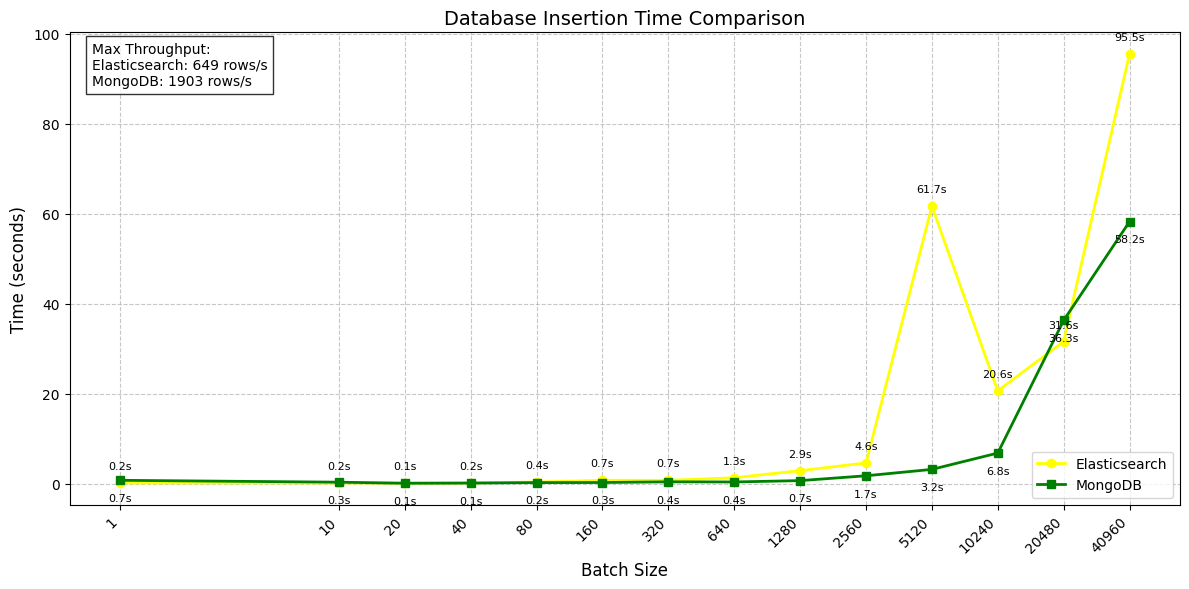

In [62]:
plot_combined_insertion_metrics(elastic_metrics, mongo_metrics)

### 2. Benchmarking Semantic Search with Elasticsearch and MongoDB


#### 2.1 Elasticsearch Semantic Search Benchmark

In [85]:
import random
from statistics import mean, stdev
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

def benchmark_search_elastic(connection, database_type="Elasticsearch", num_queries=100, concurrent_queries=[1, 10, 50, 100]):
    """
    Benchmark the vector database performance with true concurrent queries.

    Args:
        connection: Database connection
        database_type: Type of database (e.g., 'Elasticsearch', 'MongoDB')
        num_queries: Number of benchmark iterations for statistical significance
        concurrent_queries: Different concurrency levels to test
    """
    query_templates = [
        "When was YouTube officially launched, and by whom?",
        "What is YouTube's slogan introduced after Google's acquisition?",
        "How many hours of videos are collectively watched on YouTube daily?",
        "Which was the first video uploaded to YouTube, and when was it uploaded?",
        "What was the acquisition cost of YouTube by Google, and when was the deal finalized?",
        "What was the first YouTube video to reach one million views, and when did it happen?",
        "What are the three separate branches of the United States government?",
        "Which country has the highest documented incarceration rate and prison population?",
        "How many executions have occurred in the United States since 1977, and which countries have more?",
        "What percentage of the global military spending did the United States account for in 2019?",
        "How is the U.S. president elected?",
        "What cooling system innovation was included in the proposed venues for the World Cup in Qatar?",
        "What lawsuit was filed against Google in June 2020, and what was it about?",
        "How much was Google fined by CNIL in January 2022, and for what reason?",
        "When did YouTube join the NSA's PRISM program, according to reports?"
    ]

    if database_type not in benchmark_results:
        benchmark_results[database_type] = {}
    
    benchmark_results[database_type]['specific'] = {}

    def execute_single_query():
            """Execute a single query and measure its latency"""
            query = random.choice(query_templates)
            start_time = time.time()
            result = semantic_search_with_elastic(query, connection, top_n=5)
            end_time = time.time()
            return end_time - start_time

    for number_of_queries in concurrent_queries:
        latencies = []

        for _ in range(num_queries):
            with ThreadPoolExecutor(max_workers=number_of_queries) as executor:
                # Submit queries and get individual latencies
                futures = [executor.submit(execute_single_query) for _ in range(number_of_queries)]
                # Collect individual query latencies as they complete
                batch_latencies = [future.result() for future in concurrent.futures.as_completed(futures)]
                latencies.extend(batch_latencies)

        # Calculate metrics using individual query latencies
        avg_latency = mean(latencies)
        throughput = 1 / avg_latency  # Base queries per second per query
        p95_latency = sorted(latencies)[int(len(latencies) * 0.95)]
        std_dev_latency = stdev(latencies)

        benchmark_results[database_type]['specific'][number_of_queries] = {
            'avg_latency': avg_latency,
            'throughput': throughput * number_of_queries,  # Scale by concurrent queries
            'p95_latency': p95_latency,
            'std_dev': std_dev_latency
        }

    return benchmark_results

In [90]:
# Run the benchmark
try:
    client = Elasticsearch(hosts=["http://localhost:9200"], api_key=ELASTIC_API_KEY, request_timeout=3000)
    print("Running benchmark...")
    results = benchmark_search_elastic(client, database_type="Elasticsearch", num_queries=TOTAL_QUERIES, concurrent_queries=CONCURRENT_QUERIES)

except Exception as e:
    print("Benchmark failed:", e)
finally:
    client.close()
    print("\nConnection closed")

Running benchmark...

Connection closed


In [91]:
import pprint
pprint.pprint(benchmark_results['Elasticsearch'])

{'incremental_insert': {1: {'batch_size': 1,
                            'rows_per_second': 6.584330304091125,
                            'total_time': 0.15187573432922363},
                        10: {'batch_size': 10,
                             'rows_per_second': 65.67278409562417,
                             'total_time': 0.15227007865905762},
                        20: {'batch_size': 20,
                             'rows_per_second': 169.98709180623524,
                             'total_time': 0.11765599250793457},
                        40: {'batch_size': 40,
                             'rows_per_second': 249.15744670739784,
                             'total_time': 0.16054105758666992},
                        80: {'batch_size': 80,
                             'rows_per_second': 223.7606564023772,
                             'total_time': 0.3575248718261719},
                        160: {'batch_size': 160,
                              'rows_per_second': 215.429397

#### 2.2 MongoDB Semantic Search Benchmark

In [133]:
def benchmark_search_mongo(collection, database_type="MongoDB", num_queries=100, concurrent_queries=[1, 10, 50, 100]):
    """
    Benchmark MongoDB vector search with true concurrency.

    Args:
        collection: MongoDB collection object
        database_type: Type of database (default: "MongoDB")
        num_queries: Number of benchmark iterations for statistical significance
        batch_sizes: Different concurrency levels to test
    """
    query_templates = [
        "When was YouTube officially launched, and by whom?",
        "What is YouTube's slogan introduced after Google's acquisition?",
        "How many hours of videos are collectively watched on YouTube daily?",
        "Which was the first video uploaded to YouTube, and when was it uploaded?",
        "What was the acquisition cost of YouTube by Google, and when was the deal finalized?",
        "What was the first YouTube video to reach one million views, and when did it happen?",
        "What are the three separate branches of the United States government?",
        "Which country has the highest documented incarceration rate and prison population?",
        "How many executions have occurred in the United States since 1977, and which countries have more?",
        "What percentage of the global military spending did the United States account for in 2019?",
        "How is the U.S. president elected?",
        "What cooling system innovation was included in the proposed venues for the World Cup in Qatar?",
        "What lawsuit was filed against Google in June 2020, and what was it about?",
        "How much was Google fined by CNIL in January 2022, and for what reason?",
        "When did YouTube join the NSA's PRISM program, according to reports?"
    ]

    if database_type not in benchmark_results:
        benchmark_results[database_type] = {}
    
    benchmark_results[database_type]['specific'] = {}

    def execute_single_query():
        """Execute a single query with MongoDB connection"""
        query = random.choice(query_templates)
        start_time = time.time()
        result = semantic_search_with_mongodb(query, collection, top_n=5, vector_search_index_name="vector_index_quantized")
        end_time = time.time()
        return end_time - start_time

    for number_of_queries in concurrent_queries:
        latencies = []

        for _ in range(num_queries):
            with ThreadPoolExecutor(max_workers=number_of_queries) as executor:
                # Submit queries and get individual latencies
                futures = [executor.submit(execute_single_query) for _ in range(number_of_queries)]
                # Collect individual query latencies
                batch_latencies = [future.result() for future in concurrent.futures.as_completed(futures)]
                latencies.extend(batch_latencies)

        # Calculate metrics using individual query latencies
        avg_latency = mean(latencies)
        throughput = 1 / avg_latency  # Queries per second per query
        p95_latency = sorted(latencies)[int(len(latencies) * 0.95)]
        std_dev_latency = stdev(latencies)

        # Store results
        benchmark_results[database_type]['specific'][number_of_queries] = {
            'avg_latency': avg_latency,
            'throughput': throughput * number_of_queries,  # Scale by concurrent queries
            'p95_latency': p95_latency,
            'std_dev': std_dev_latency
        }

    return benchmark_results[database_type]

In [134]:
# Run the benchmark for MongoDB
try:
    mongo_client = get_mongo_client(MONGO_URI)
    db = mongo_client[DB_NAME]
    collection = db[COLLECTION_NAME]

    print("Running MongoDB benchmark...")
    results = benchmark_search_mongo(collection, num_queries=TOTAL_QUERIES, concurrent_queries=CONCURRENT_QUERIES)
    
except Exception as e:
    print("MongoDB benchmark failed:", e)
finally:
    mongo_client.close()
    print("\nMongoDB connection closed")

Connection to MongoDB successful
Running MongoDB benchmark...

MongoDB connection closed


In [135]:
print(benchmark_results)

{'Elasticsearch': {'insert_time': {'total_time': 60.994911909103394, 'rows_per_second': 296.56572054660586, 'total_rows': 18089}, 'incremental_insert': {1: {'total_time': 0.15187573432922363, 'rows_per_second': 6.584330304091125, 'batch_size': 1}, 10: {'total_time': 0.15227007865905762, 'rows_per_second': 65.67278409562417, 'batch_size': 10}, 20: {'total_time': 0.11765599250793457, 'rows_per_second': 169.98709180623524, 'batch_size': 20}, 40: {'total_time': 0.16054105758666992, 'rows_per_second': 249.15744670739784, 'batch_size': 40}, 80: {'total_time': 0.3575248718261719, 'rows_per_second': 223.7606564023772, 'batch_size': 80}, 160: {'total_time': 0.7427027225494385, 'rows_per_second': 215.4293974455567, 'batch_size': 160}, 320: {'total_time': 0.7366189956665039, 'rows_per_second': 434.41725217859636, 'batch_size': 320}, 640: {'total_time': 1.307582139968872, 'rows_per_second': 489.4529991173141, 'batch_size': 640}, 1280: {'total_time': 2.8873252868652344, 'rows_per_second': 443.31686

#### 2.3 Visualize Semantic Search Benchmark

In [136]:
import numpy as np

def bar_chart_benchmark_comparison(benchmark_results, metric="avg_latency", metric_label="Average Latency (ms)"):
    """
    Generates bar charts to compare benchmark results for each metric across databases.

    Args:
        benchmark_results (dict): Benchmark results structured as a nested dictionary.
        metric (str): The performance metric to visualize (e.g., "avg_latency", "throughput").
        metric_label (str): The label to display for the metric.
    """
    # Extract data for the bar chart
    query_types = ["specific"]
    batch_sizes = CONCURRENT_QUERIES
    data = []

    for query_type in query_types:
        for batch_size in batch_sizes:
            row = {"Batch Size": batch_size, "Query Type": query_type}
            for db_type in benchmark_results:
                # Safely extract metric values or default to None
                value = benchmark_results[db_type].get(query_type, {}).get(batch_size, {}).get(metric, None)
                # Scale values if necessary
                if value is not None and metric in ["avg_latency", "p95_latency"]:
                    value *= 1000  # Convert to ms
                row[db_type] = value
            data.append(row)

    # Convert the data into a plot-friendly structure
    for query_type in query_types:
        labels = [str(batch_size) for batch_size in batch_sizes]
        mongodb_values = [row["MongoDB"] for row in data if row["Query Type"] == query_type]
        elastic_values = [row["Elasticsearch"] for row in data if row["Query Type"] == query_type]

        # Create the bar chart
        fig, ax = plt.subplots(figsize=(15, 6))
        
        # Set the width of each bar and positions of the bars
        width = 0.35
        x = np.arange(len(batch_sizes))
        
        # Create bars
        elastic_bars = ax.bar(x - width/2, elastic_values, width, label='Elasticsearch', color='yellow', edgecolor='yellow')
        mongodb_bars = ax.bar(x + width/2, mongodb_values, width, label='MongoDB', color='green', edgecolor='green')

        # Add grid
        ax.grid(True, linestyle='--', alpha=0.7, axis='y')

        # Add titles and labels
        ax.set_title(f"{metric_label} Comparison for {query_type.capitalize()} Queries", pad=20)
        ax.set_xlabel("Concurrent Queries", labelpad=10)
        ax.set_ylabel(metric_label, labelpad=10)

        # Set x-axis ticks
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=45, ha='right')

        # Add legend
        ax.legend(fontsize=10)

        # Add value labels on top of bars
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.2f}',
                          xy=(rect.get_x() + rect.get_width() / 2, height),
                          xytext=(0, 3),  # 3 points vertical offset
                          textcoords="offset points",
                          ha='center', va='bottom',
                          rotation=90,
                          fontsize=8)

        autolabel(elastic_bars)
        autolabel(mongodb_bars)

        plt.tight_layout()
        plt.show()

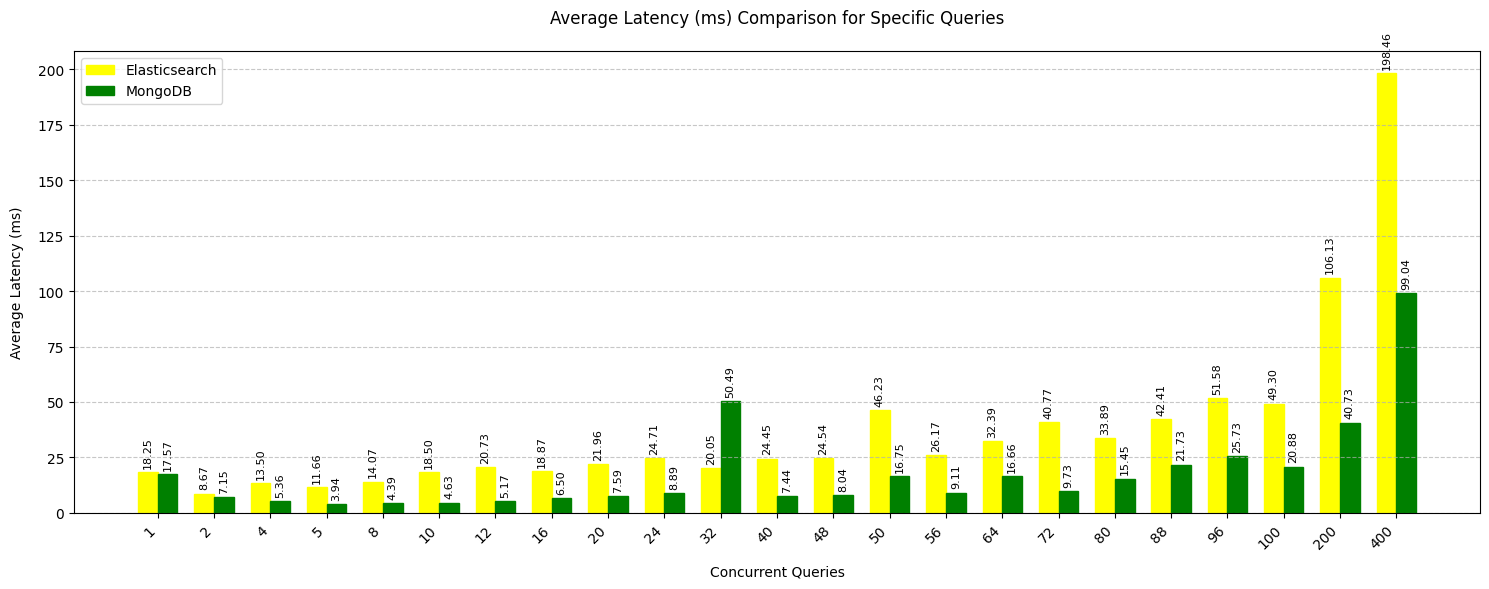

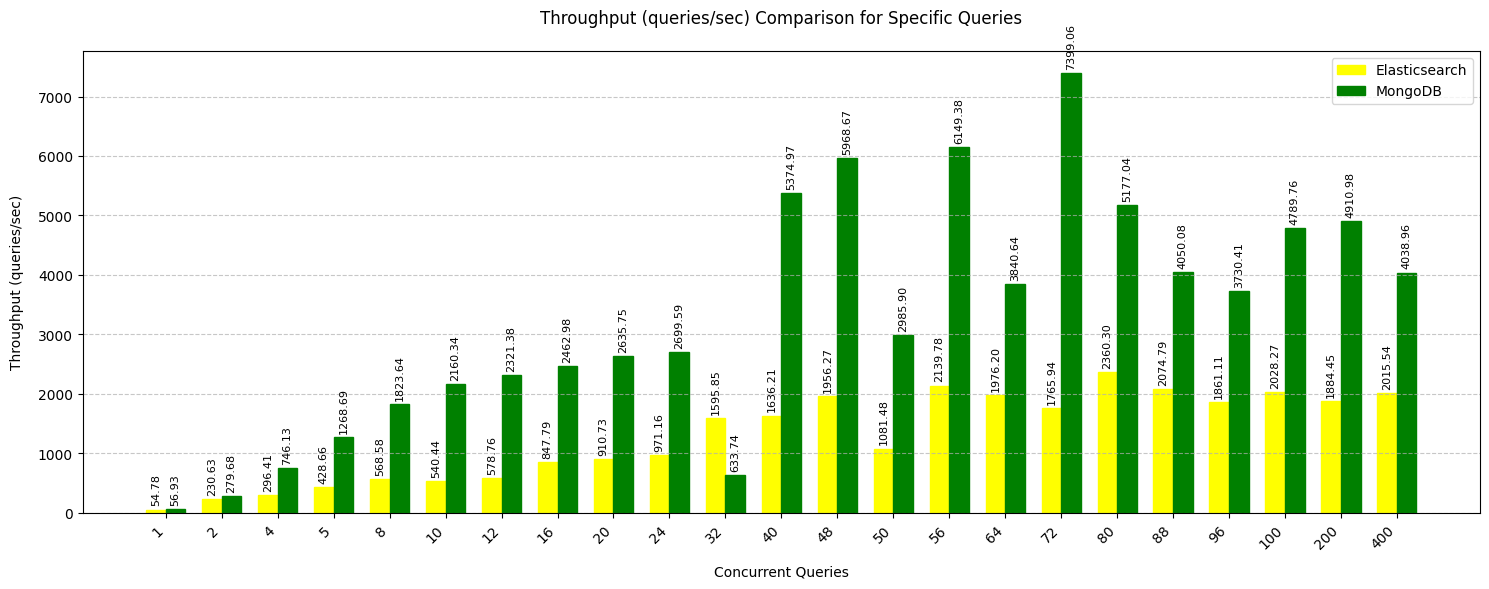

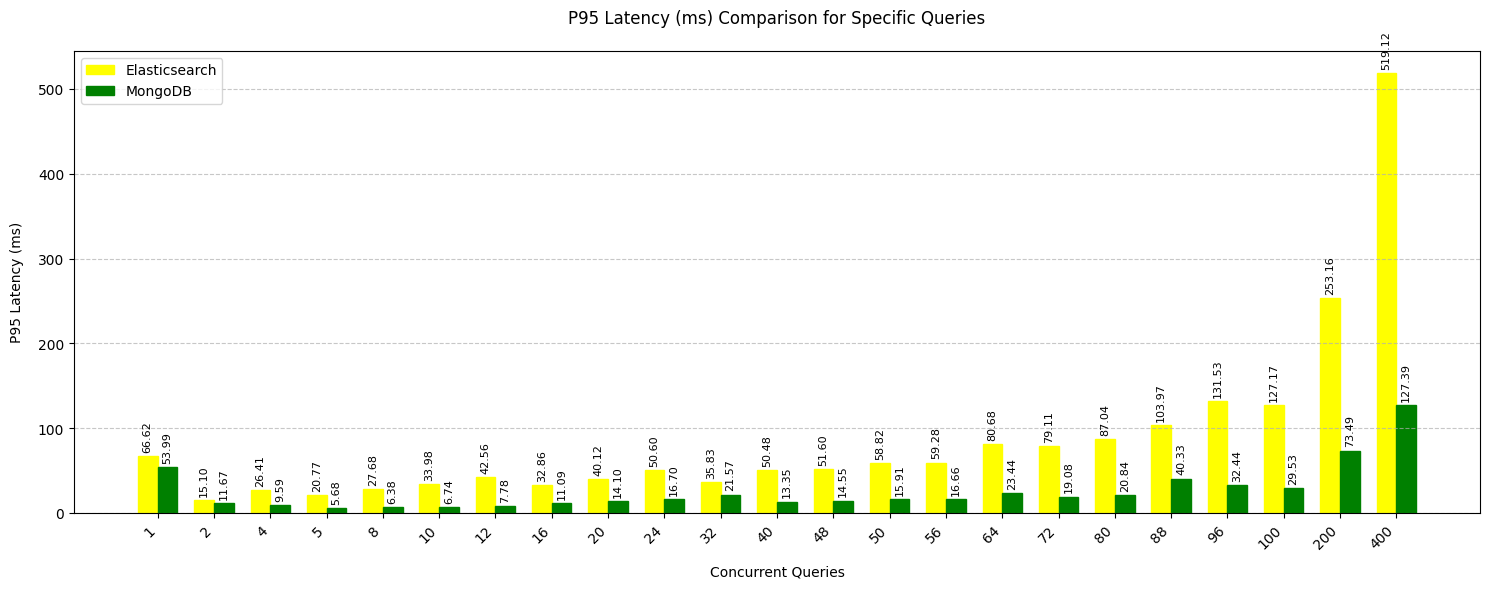

In [137]:
# Generate bar charts for each metric
bar_chart_benchmark_comparison(benchmark_results, metric="avg_latency", metric_label="Average Latency (ms)")
bar_chart_benchmark_comparison(benchmark_results, metric="throughput", metric_label="Throughput (queries/sec)")
bar_chart_benchmark_comparison(benchmark_results, metric="p95_latency", metric_label="P95 Latency (ms)")